In [181]:
import pandas as pd
import math
import numpy as np
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.spatial.distance import cdist,cityblock
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns

In [171]:
data_path = "min_max_normalized_data.csv"
df = pd.read_csv(data_path)
columns = ['winter_PSurf', 'spring_PSurf', 'summer_PSurf', 'autumn_PSurf',
    'winter_Qair', 'spring_Qair', 'summer_Qair', 'autumn_Qair',
    'winter_Tair', 'spring_Tair', 'summer_Tair', 'autumn_Tair',
    'winter_Wind', 'spring_Wind', 'summer_Wind', 'autumn_Wind',
    'lon', 'lat',
    'sand % topsoil', 'silt % topsoil', 
    'clay % topsoil', 'OC % topsoil', 'OC % subsoil', 'N % topsoil',
    'N % subsoil', 'CaCO3 % topsoil', 
    ]
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f'train set shape : {train_df.shape[0]} , test set shape : {test_df.shape[0]}')

train set shape : 686 , test set shape : 172


Decesion Tree From scratch

In [2]:
def entropy(df,target):

    total = len(df) 
    
    # claculating the probabilities pi 
    probabilities = df[target].value_counts(normalize=True)  # this equivalent to count / total

    # Calculate entropy
    entropy = -sum(pi * math.log2(pi) for pi in probabilities if pi > 0)

    return entropy 

In [3]:
def gain(df,total_entropy,attribute,target):
    
    total = len(df)

    # Group by attribute values
    grouped = df.groupby(attribute)

    weighted_entropy = sum(
        (len(group) / total) * entropy(group, target)
        for _, group in grouped
    )
    # Calculate information gain
    info_gain = total_entropy - weighted_entropy

    return info_gain

In [57]:
def gain_continuous(df, total_entropy, attribute, target):
    """
    Calculate information gain for a continuous-valued attribute.
    :param df: DataFrame containing the dataset.
    :param total_entropy: Total entropy of the dataset.
    :param attribute: Continuous attribute to calculate gain for.
    :param target: Target column.
    :return: Best split point and the information gain.
    """
    # Sort the dataset by the continuous attribute
    df = df.sort_values(by=attribute)
    
    # Get all unique values of the attribute
    values = df[attribute].unique()
    
    # Compute midpoints between adjacent values as potential split points
    split_points = [(values[i] + values[i + 1]) / 2 for i in range(len(values) - 1)]
    
    best_gain = -float('inf')
    best_split = None
    
    # Evaluate each split point
    for split_point in split_points:
        # Partition the dataset based on the split point
        left_partition = df[df[attribute] <= split_point]
        right_partition = df[df[attribute] > split_point]
        
        # Calculate weighted entropy for the split
        weighted_entropy = (
            (len(left_partition) / len(df)) * entropy(left_partition, target) +
            (len(right_partition) / len(df)) * entropy(right_partition, target)
        )
        
        # Calculate information gain
        info_gain = total_entropy - weighted_entropy
        
        # Keep track of the best split
        if info_gain > best_gain:
            best_gain = info_gain
            best_split = split_point

    return best_split, best_gain

In [120]:
data = {
    'Temperature': [85, 80, 83, 70, 65, 72, 75, 90, 88, 76, 78, 82, 68, 60],  # Continuous
    'Humidity': [85, 90, 86, 96, 70, 80, 70, 60, 75, 82, 95, 65, 55, 50],      # Continuous
    'WindSpeed': [5, 10, 12, 7, 8, 4, 9, 6, 11, 7, 3, 13, 8, 2],               # Continuous
    'Pressure': [1015, 1012, 1013, 1020, 1022, 1018, 1016, 1011, 1014, 1017, 1010, 1025, 1019, 1009],  # Continuous
    'PlayTennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No']  # Target
}
df = pd.DataFrame(data)
attributes = ['Temperature', 'Humidity', 'WindSpeed', 'Pressure']
target = 'PlayTennis'

# Calculate entropy of the target column
total_entropy = entropy(df, 'PlayTennis')
print("Total entropy:", total_entropy)

# Calculate gain for the attribute 'Temperature'
info_gain = gain(df, total_entropy, 'Temperature', 'PlayTennis')
print("Information Gain for Temperature:", info_gain)

Total entropy: 1.0
Information Gain for Temperature: 1.0


In [121]:
best_split, best_gain = gain_continuous(df, total_entropy, 'Temperature', 'PlayTennis')
print(f'{best_split}, {best_gain}')

62.5, 0.07539593734971184


In [110]:
def select_attribute(df, total_entropy, attributes, target):
    """
    Select the best attribute to split on, considering both categorical and continuous attributes.
    """
    info_gains = []
    splits = {}

    for attribute in attributes:
        if df[attribute].dtype in ['int32', 'int64', 'float32', 'float64']:  # Continuous attribute
            best_split, gain_value = gain_continuous(df, total_entropy, attribute, target)
            #print(f'{attribute} : {best_split}, {best_gain}')
            splits[attribute] = best_split  # Store the best split point
        else:  # Categorical attribute
            gain_value = gain(df, total_entropy, attribute, target)
            #print(f'{attribute} : {gain_value}')
        
        info_gains.append((attribute, gain_value))
    
    # Select the attribute with the maximum information gain
    best_attribute = max(info_gains, key=lambda x: x[1])[0]

    return best_attribute, splits.get(best_attribute, None)  # Return split point if applicable

In [122]:
best_attribute = select_attribute(df, total_entropy, attributes, 'PlayTennis')
print("Best attribute:", best_attribute)

Best attribute: ('Humidity', 62.5)


In [139]:
class Node:
    def __init__(self, data):
        """
        Initialize a node with data and optionally its children.
        """
        self.data = data  # Node data (e.g., attribute name, condition, or leaf)
        self.children = []  # List of child nodes

    def add_child(self, child):
        """
        Add a child node to the current node.
        """
        self.children.append(child)


In [140]:
def decision_tree_algorithm(df, attributes, target, root=None, parentNode=None):
    """
    Build a decision tree using continuous attributes.
    """
    # Stopping condition: if no attributes left or all target values are the same
    if not attributes or len(df[target].unique()) == 1:
        leaf_value = df[target].mode()[0]  # Most common target value
        leaf_node = Node(f"Leaf={leaf_value}")
        if parentNode:  # Attach the leaf node to the parent
            parentNode.add_child(leaf_node)
        return root or leaf_node

    # Calculate total entropy
    total_entropy = entropy(df, target)

    # Select the best attribute to split on
    best_attribute, split_point = select_attribute(df, total_entropy, attributes, target)

    # Create the root node if it doesn't exist
    if root is None:
        root = Node(best_attribute)  # The root is the best attribute at this level
        parentNode = root

    # Create condition nodes for the split
    if split_point is not None:
        left_condition = Node(f"{best_attribute} <= {split_point}")
        right_condition = Node(f"{best_attribute} > {split_point}")

        parentNode.add_child(left_condition)
        parentNode.add_child(right_condition)

        # Recursively build the left and right subtrees
        left_partition = df[df[best_attribute] <= split_point]
        right_partition = df[df[best_attribute] > split_point]

        if not left_partition.empty:
            decision_tree_algorithm(left_partition, attributes, target, root=root, parentNode=left_condition)
        if not right_partition.empty:
            decision_tree_algorithm(right_partition, attributes, target, root=root, parentNode=right_condition)

    return root


In [141]:
def predict(node, instance):
    """
    Predict the target value for a given instance using a decision tree.
    """
    # Traverse the tree until a leaf node is reached
    while node:
        print(f"Current node: {node.data}")

        # If the current node is a leaf, return the prediction
        if node.data.startswith("Leaf="):
            prediction = node.data.split("=")[1]
            print(f"Leaf reached: returning {prediction}")
            return prediction

        # Handle conditions in the current node
        if "<=" in node.data:
            attribute_name, threshold = node.data.split(" <= ")
            threshold = float(threshold)
            attribute_value = instance.get(attribute_name)

            print(f"Evaluating: {attribute_name} <= {threshold}?")

            # Follow the left or right child based on the condition
            if attribute_value <= threshold:
                print(f"{attribute_name} <= {threshold}, moving to the left child...")
                node = node.children[0]
            else:
                print(f"{attribute_name} > {threshold}, moving to the right child...")
                node = node.children[1]
        elif ">" in node.data:
            # Handle cases with ">"
            attribute_name, threshold = node.data.split(" > ")
            threshold = float(threshold)
            attribute_value = instance.get(attribute_name)

            print(f"Evaluating: {attribute_name} > {threshold}?")

            if attribute_value > threshold:
                print(f"{attribute_name} > {threshold}, moving to the right child...")
                node = node.children[1]
            else:
                print(f"{attribute_name} <= {threshold}, moving to the left child...")
                node = node.children[0]

    # If no valid path is found (edge case)
    print("No match found, returning None")
    return None


In [9]:
def print_tree(node, depth=0):
    print("  " * depth + str(node.data))
    for child in node.children:
        print_tree(child, depth + 1)

In [ ]:
# Sample instances for prediction
sample_instance1 = {'Temperature': 75, 'Humidity': 60, 'WindSpeed': 6, 'Pressure': 1010}
sample_instance2 = {'Temperature': 85, 'Humidity': 90, 'WindSpeed': 12, 'Pressure': 1018}

root = decision_tree_algorithm(df, attributes, target)
print_tree(root)

In [ ]:
prediction = predict(root, sample_instance1)
print("Prediction for sample_instance:", prediction)

prediction2 = predict(root, sample_instance2)
print("Prediction for sample_instance2:", prediction2)


In [ ]:
'''def predict(node, instance):
    """
    Predict the target value for a given instance using a tree with continuous attributes.
    """
    # Traverse the tree until a leaf is reached
    while node:
        print(f'Current node: {node.data}')

        # If the current node is a leaf, return the prediction
        if node.data.startswith("Leaf="):
            prediction = node.data.split("=")[1]
            print(f'Leaf reached: returning {prediction}')
            return prediction

        # Handle continuous splits
        if '<=' in node.data:
            attribute_name, threshold = node.data.split(' <= ')
            threshold = float(threshold)
            attribute_value = instance.get(attribute_name)

            print(f'Evaluating: {attribute_name} <= {threshold}?')

            # Follow the appropriate branch based on the condition
            if attribute_value <= threshold:
                print(f'{attribute_name} <= {threshold}, moving to the left child...')
                node = node.children[0]  # Left child
            else:
                print(f'{attribute_name} > {threshold}, moving to the right child...')
                node = node.children[1]  # Right child
        else:
            node = node.children[0]

    # If no valid path is found (edge case)
    print('No match found, returning None')
    return None

    
data = {
    'Temperature': [85, 80, 83, 70, 65, 72, 75, 90, 88, 76, 78, 82, 68, 60],  # Continuous
    'Humidity': [85, 90, 86, 96, 70, 80, 70, 60, 75, 82, 95, 65, 55, 50],      # Continuous
    'WindSpeed': [5, 10, 12, 7, 8, 4, 9, 6, 11, 7, 3, 13, 8, 2],               # Continuous
    'Pressure': [1015, 1012, 1013, 1020, 1022, 1018, 1016, 1011, 1014, 1017, 1010, 1025, 1019, 1009],  # Continuous
    'PlayTennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No']  # Target
}
df = pd.DataFrame(data)

# Sample instances for prediction
sample_instance1 = {'Temperature': 75, 'Humidity': 60, 'WindSpeed': 6, 'Pressure': 1010}
sample_instance2 = {'Temperature': 85, 'Humidity': 90, 'WindSpeed': 12, 'Pressure': 1018}

root = decision_tree_algorithm(df, attributes, target)
print_tree(root)


prediction = predict(root, sample_instance1)
print("Prediction for sample_instance:", prediction)

prediction2 = predict(root, sample_instance2)
print("Prediction for sample_instance2:", prediction2)


    '''

DBSCAN

In [144]:

def calculate_distances(df, columns, metric='cityblock'):
    """
    Calculate the pairwise distances between all instances in the dataset.

    """
    # Extract the relevant data as a numpy array
    data = df[columns].to_numpy()
    
    # Compute pairwise distances using scipy's cdist for efficiency
    distances = cdist(data, data, metric=metric)
    
    return distances


In [147]:
distances = calculate_distances(df, columns)
distances

array([[0.        , 1.29382434, 1.87768492, ..., 4.98060481, 5.63629821,
        6.08537064],
       [1.29382434, 0.        , 0.61710244, ..., 5.51836367, 5.68066169,
        6.25723742],
       [1.87768492, 0.61710244, 0.        , ..., 5.32465525, 5.48695327,
        6.06352899],
       ...,
       [4.98060481, 5.51836367, 5.32465525, ..., 0.        , 1.49460261,
        2.31088347],
       [5.63629821, 5.68066169, 5.48695327, ..., 1.49460261, 0.        ,
        3.063892  ],
       [6.08537064, 6.25723742, 6.06352899, ..., 2.31088347, 3.063892  ,
        0.        ]])

In [150]:
def is_core_point(point_id, distances, Eps=1, MinPts=5):
    """
    Checks if the given point is a core point in DBSCAN.

    Parameters:
        point_id (int): The index of the point.
        distances (np.ndarray): The precomputed distance matrix.
        Eps (float): The maximum distance to consider for a point to be in the neighborhood.
        MinPts (int): The minimum number of points required in the neighborhood to be a core point.

    Returns:
        bool: True if the point is a core point, False otherwise.
    """
    # Get all distances to the point
    neighbors = np.sum(distances[point_id] <= Eps) - 1  # Subtract 1 to exclude the point itself
    
    # Return whether the point has enough neighbors
    return neighbors >= MinPts

In [152]:
print(is_core_point(50, distances))

True


In [154]:
def get_neighbors(point_id, distances, Eps=1):
    """
    Returns the indices of the neighbors of a given point.

    Parameters:
        point_id (int): The index of the point.
        distances (np.ndarray): The precomputed distance matrix.
        Eps (float): The maximum distance to consider for a point to be in the neighborhood.

    Returns:
        list: A list of indices of the neighbors of the point.
    """
    # Get all neighbors with distance less than or equal to Eps
    neighbors = np.where((distances[point_id] <= Eps) & (np.arange(len(distances)) != point_id))[0]
    
    return neighbors.tolist()

In [155]:
print(get_neighbors(50, distances))

[30, 31, 32, 40, 41, 49, 51, 61, 62, 63, 64, 74, 75, 76, 89, 90, 91]


In [164]:
import random
from collections import deque

def dbscan(df, distances, Eps=1, MinPts=5):
    # Initialize variables
    core_points = []  # List to store the indexes of core points
    non_core_points = []  # List to store the indexes of non-core points
    clusters = {}  # Dictionary to store clusters
    cluster_id = 0  # Start with the first cluster ID
    
    # Identify core and non-core points
    for i in range(len(df)):
        if is_core_point(i, distances, Eps=1, MinPts=5):
            core_points.append(i)
        else:
            non_core_points.append(i)
    
    # Process core points to form clusters
    visited = set()  # Track visited points
    while core_points:
        # Start a new cluster
        current_cluster = []
        core_point = random.choice(core_points)
        core_points.remove(core_point)
        
        # Expand the cluster using a queue
        queue = deque([core_point])  # Initialize queue with the core point
        while queue:
            current_point = queue.popleft()  # Get the next point to process
            if current_point not in visited:
                visited.add(current_point)
                current_cluster.append(current_point)

                # Get neighbors of the current point
                neighbors = get_neighbors(current_point, distances, Eps=1)
                for neighbor in neighbors:
                    if neighbor in core_points:  # If it's a core point
                        # Remove it from core_points and add it to the queue
                        core_points.remove(neighbor)
                        queue.append(neighbor)  # Expand the cluster using this neighbor
                    elif neighbor in non_core_points:  # If it's a non-core point
                        non_core_points.remove(neighbor)  # Remove it since it's already assigned
                        current_cluster.append(neighbor)  # Add to the cluster directly
        
        # Add the fully expanded cluster to the clusters dictionary
        clusters[cluster_id] = current_cluster
        cluster_id += 1

    # Assign non-core points to the nearest cluster, if possible
    for non_core_point in non_core_points:
        for cluster_id, cluster_points in clusters.items():
            if any(distances[non_core_point][point] <= Eps for point in cluster_points):
                clusters[cluster_id].append(non_core_point)
                break  # Stop after assigning to the first valid cluster
    
    # Labeling the clusters in the DataFrame
    cluster_labels = [-1] * len(df)  # Default label is -1 (noise)
    for cluster_id, cluster_points in clusters.items():
        for point in cluster_points:
            cluster_labels[point] = cluster_id
    
    # Add cluster labels to the DataFrame
    df['cluster'] = cluster_labels

    return df,clusters


In [165]:
result_df, clusters = dbscan(df, distances, Eps=1, MinPts=5)
print(result_df['cluster'])

0      -1
1      20
2      20
3      -1
4       0
       ..
853    -1
854    -1
855    -1
856    -1
857    -1
Name: cluster, Length: 858, dtype: int64


In [162]:
def predict_cluster(new_sample, clusters, df, distances, Eps, columns):
    """
    Predict the cluster of a new sample based on trained DBSCAN clusters.

    Parameters:
    - new_sample: Array-like, the new sample to classify (must match the feature space defined by columns).
    - clusters: Dictionary of clusters created by DBSCAN.
    - df: DataFrame containing the dataset (used for feature extraction).
    - distances: Precomputed distance matrix for the dataset.
    - Eps: Float, the neighborhood radius used during training.
    - columns: List of column names used for clustering.

    Returns:
    - cluster_id: The predicted cluster ID for the new sample (-1 if noise).
    """
    # Ensure the new_sample is an array-like object with the correct number of features
    new_sample = np.array(new_sample)
    if len(new_sample) != len(columns):
        raise ValueError(f"new_sample must have {len(columns)} features to match the defined columns.")

    # Calculate distances from the new sample to all points in the dataset using the specified columns
    new_sample_distances = []
    for i in range(len(df)):
        distance = cityblock(new_sample, df.iloc[i][columns].values) #equivalent to distance = np.sum(np.abs(new_sample - df.iloc[i][columns].values))
        new_sample_distances.append(distance)
    
    # Check for the nearest cluster
    for cluster_id, cluster_points in clusters.items():
        # Check if any point in the cluster is within Eps
        if any(new_sample_distances[point] <= Eps for point in cluster_points):
            return cluster_id


    # If no cluster is found within Eps, classify as noise
    return -1


In [169]:
# Example new sample (must match the number of columns)
X = {
    'winter_PSurf': 1012.5, 'spring_PSurf': 1013.2, 'summer_PSurf': 1015.1, 'autumn_PSurf': 1014.3,  # PSurf
    'winter_Qair': 0.005, 'spring_Qair': 0.006, 'summer_Qair': 0.004, 'autumn_Qair': 0.005,          # Qair
    'winter_Tair': 15.2, 'spring_Tair': 18.5, 'summer_Tair': 22.1, 'autumn_Tair': 10.5,             # Tair
    'winter_Wind': 3.2, 'spring_Wind': 3.6, 'summer_Wind': 2.9, 'autumn_Wind': 3.1,                 # Wind
    'lon': -120.3, 'lat': 35.7,                                                                    # lon, lat
    'sand % topsoil': 55, 'silt % topsoil': 30, 'clay % topsoil': 15,                              # Soil composition
    'OC % topsoil': 2.1, 'OC % subsoil': 1.8,                                                     # Organic Carbon
    'N % topsoil': 0.3, 'N % subsoil': 0.25,                                                      # Nitrogen
    'CaCO3 % topsoil': 0.4                                                                        # Calcium Carbonate
}


new_sample = pd.DataFrame([X])
new_sample = new_sample.iloc[0]

# Predict cluster
predicted_cluster = predict_cluster(new_sample, clusters, df, distances, Eps=1, columns=columns)
print(f"The predicted cluster for the new sample is: {predicted_cluster}")


The predicted cluster for the new sample is: -1


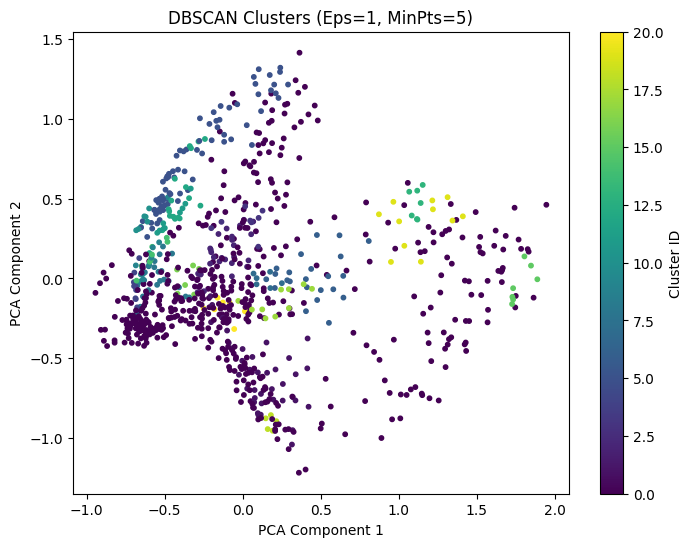

In [175]:
# Map clusters to a list of cluster labels for each data point
cluster_labels = np.zeros(len(result_df)) 
for cluster_id, indices in clusters.items():
    cluster_labels[indices] = cluster_id


pca = PCA(n_components=2)
df_scaled = result_df.drop(columns=['cluster']) 
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('DBSCAN Clusters (Eps=1, MinPts=5)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster ID')
plt.show()

In [179]:
def dbscan_with_eval(df, distances, Eps_values, MinPts_values):
    results = []

    for Eps in Eps_values:
        for MinPts in MinPts_values:
            # Call your custom dbscan function
            result_df, clusters = dbscan(df, distances, Eps=Eps, MinPts=MinPts)

            # Number of clusters (ignoring noise, which is labeled as -1)
            num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
            num_noise = list(clusters).count(-1)


            cluster_labels = np.zeros(len(result_df)) 
            for cluster_id, indices in clusters.items():
                 cluster_labels[indices] = cluster_id

            # Store results for comparison
            results.append({
                'Eps': Eps,
                'MinPts': MinPts,
                'num_clusters': num_clusters,
                'num_noise': num_noise,
                'silhouette_score': silhouette_score(df, cluster_labels) if num_clusters > 1 else -1
            })           

            # Apply PCA for dimensionality reduction to 2D
            pca = PCA(n_components=2)
            df_scaled = result_df.drop(columns=['cluster'])  # Assuming 'cluster' is the column with the labels
            df_pca = pca.fit_transform(df_scaled)

            # Plot the clusters
            plt.figure(figsize=(8, 6))
            plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster_labels, cmap='viridis', s=10)
            plt.title(f'DBSCAN Clusters (Eps={Eps}, MinPts={MinPts})')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.colorbar(label='Cluster ID')
            plt.show()

    return pd.DataFrame(results)

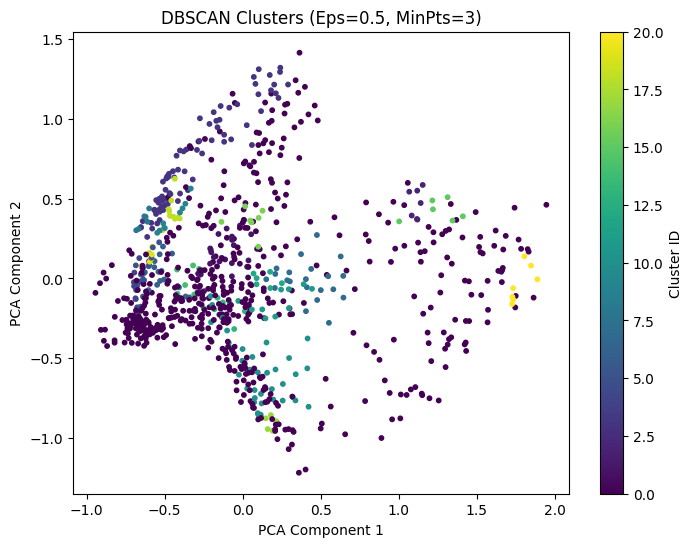

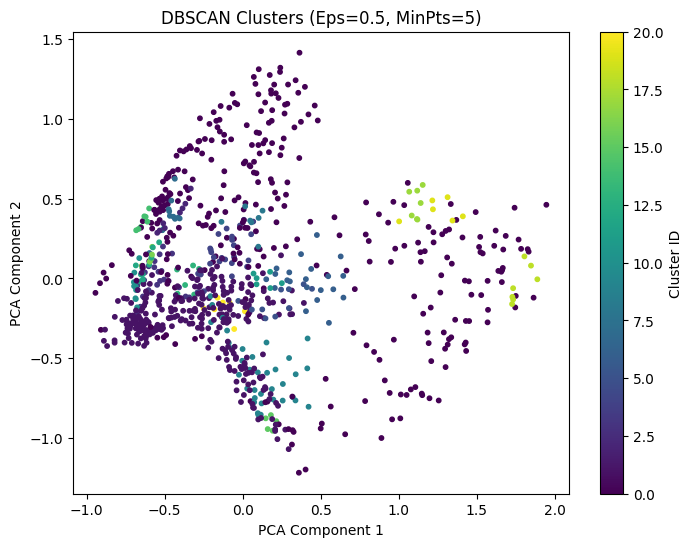

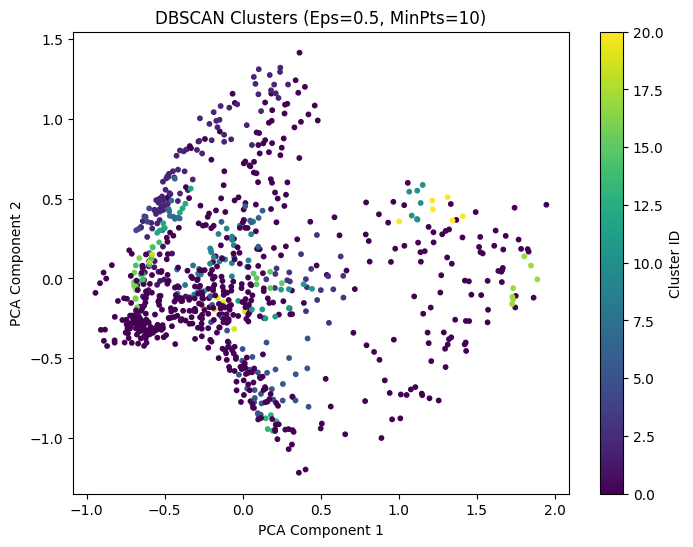

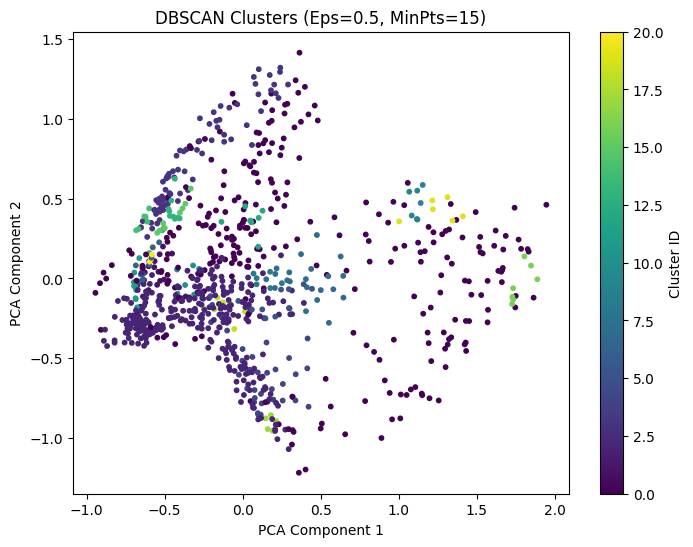

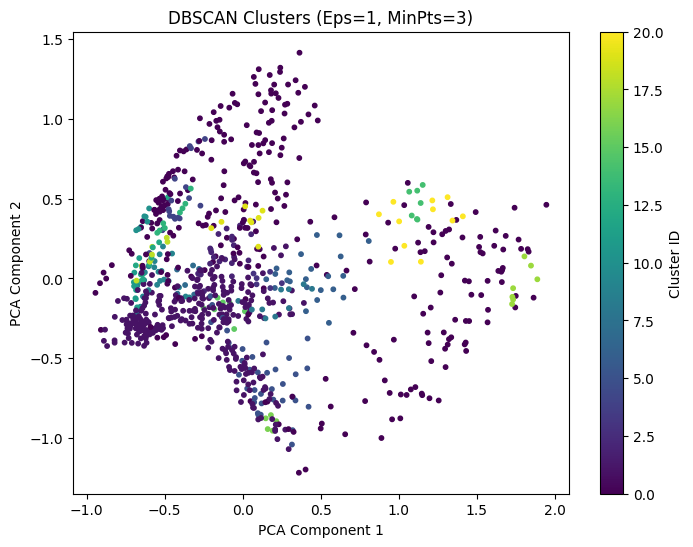

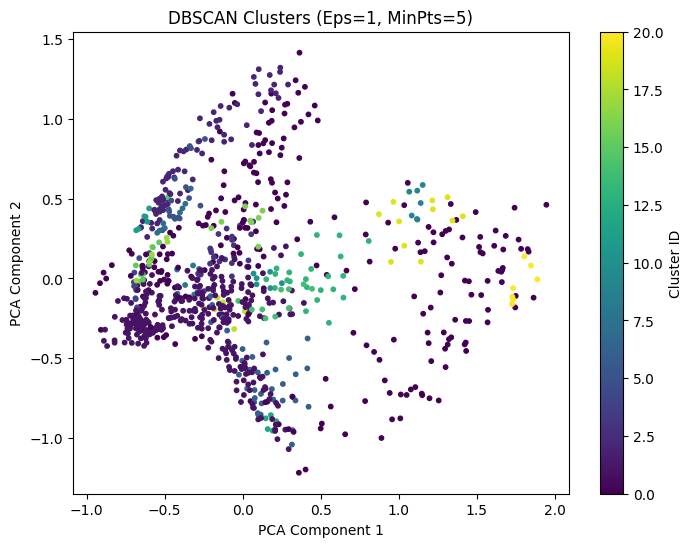

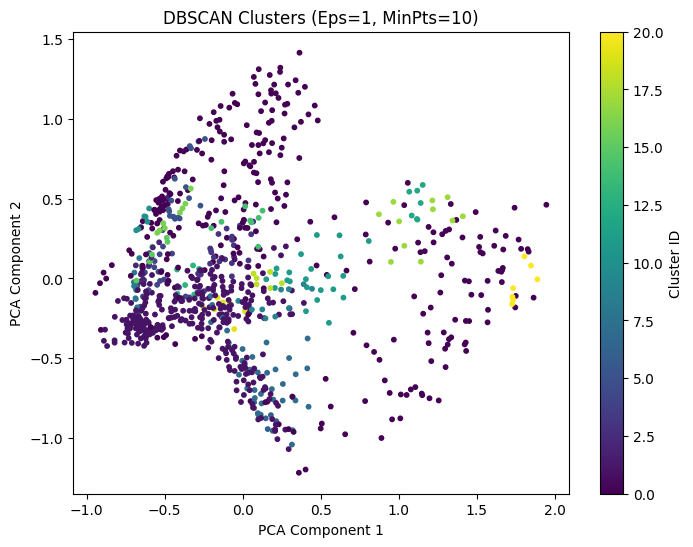

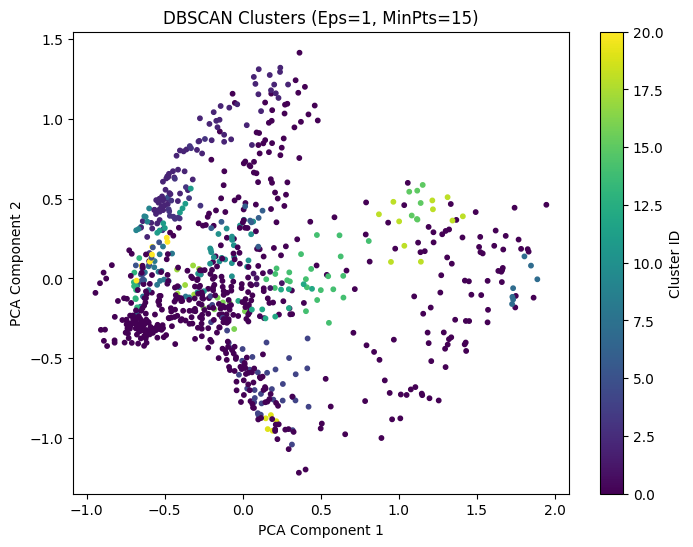

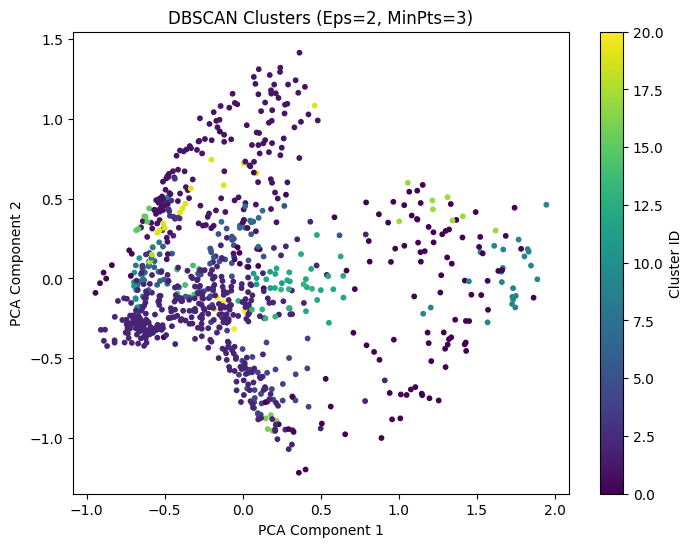

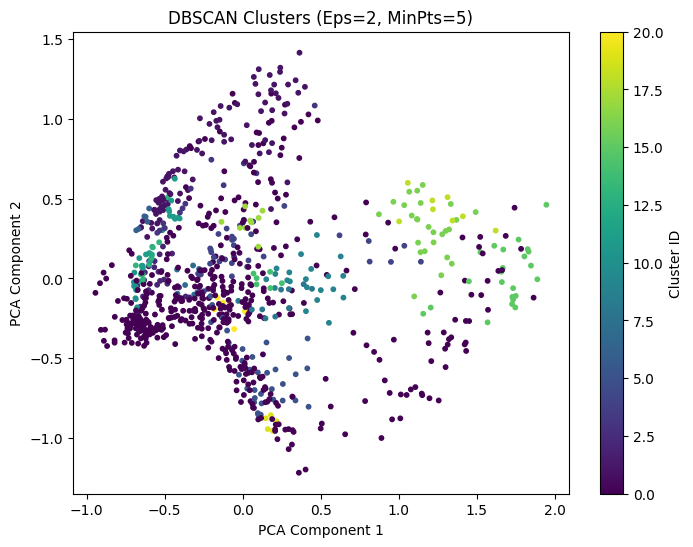

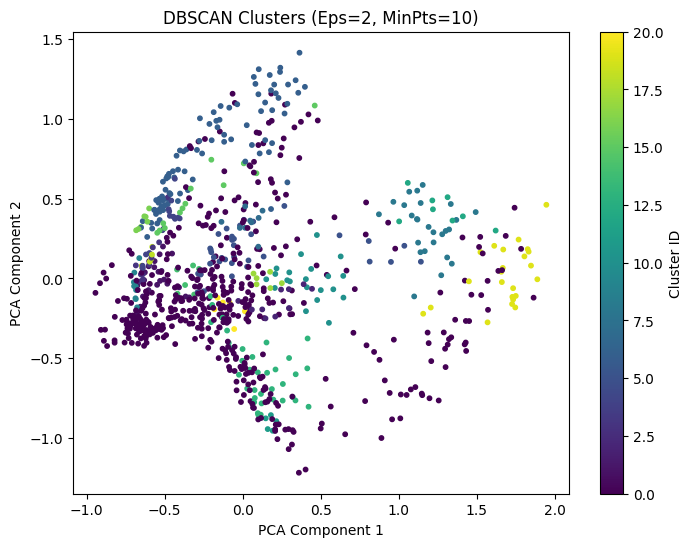

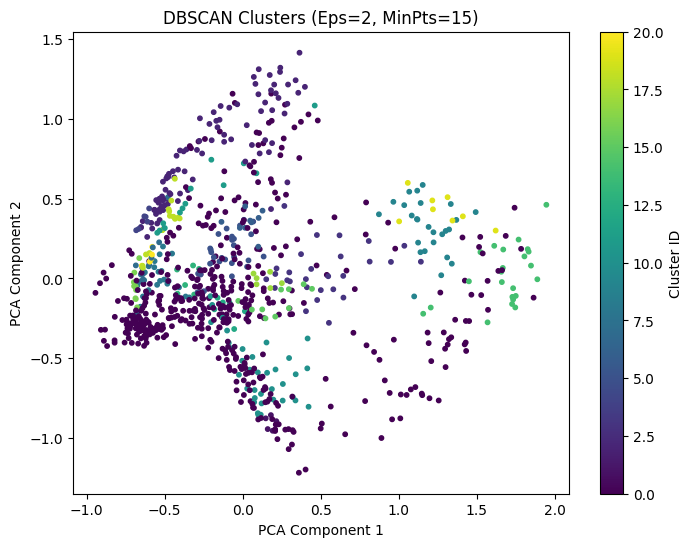

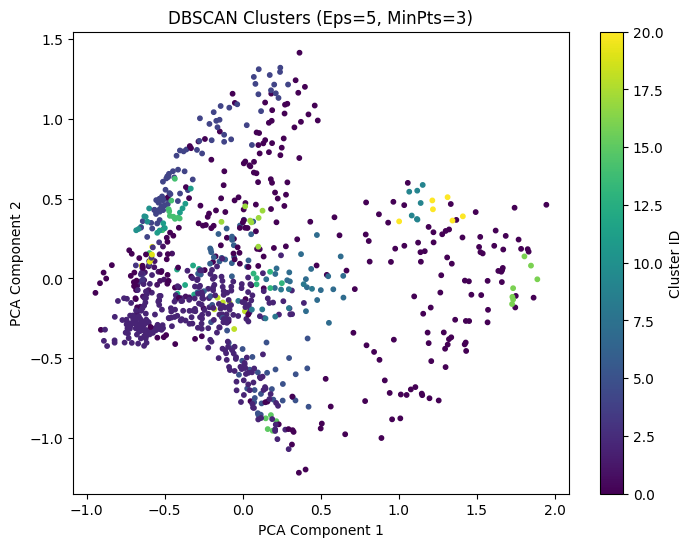

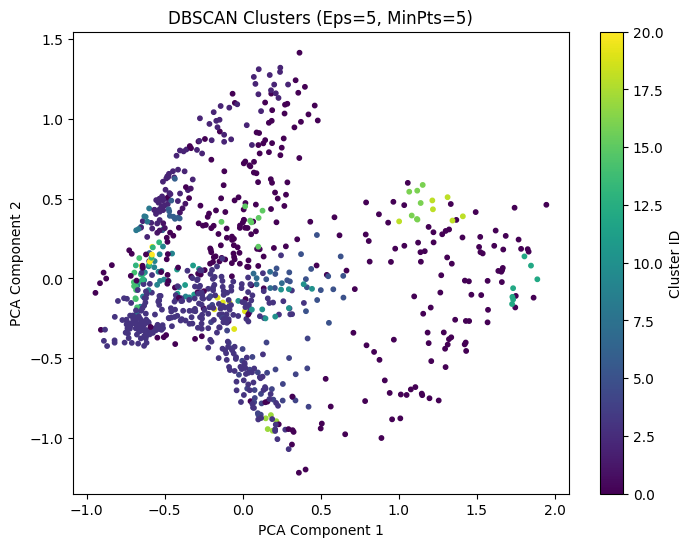

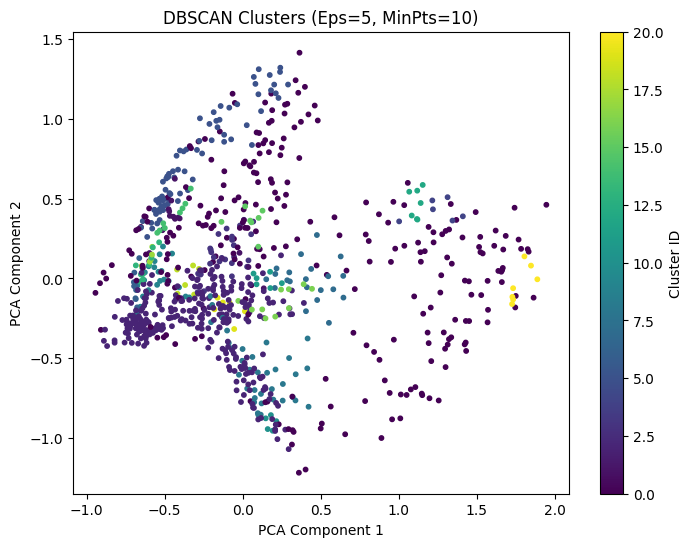

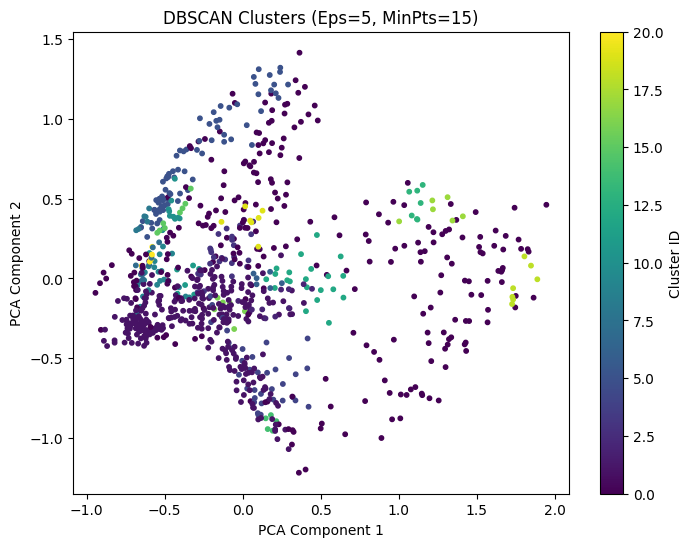

    Eps  MinPts  num_clusters  num_noise  silhouette_score
0   0.5       3            21          0          0.390127
1   0.5       5            21          0          0.496171
2   0.5      10            21          0          0.385891
3   0.5      15            21          0          0.495498
4   1.0       3            21          0          0.474766
5   1.0       5            21          0          0.531896
6   1.0      10            21          0          0.493896
7   1.0      15            21          0          0.388436
8   2.0       3            21          0          0.512964
9   2.0       5            21          0          0.469372
10  2.0      10            21          0          0.418562
11  2.0      15            21          0          0.454470
12  5.0       3            21          0          0.439420
13  5.0       5            21          0          0.438023
14  5.0      10            21          0          0.433632
15  5.0      15            21          0          0.4492

In [180]:
Eps_values = [0.5, 1, 2, 5]  # Example values for Eps
MinPts_values = [3, 5, 10, 15]  # Example values for MinPts

# Run DBSCAN with different parameters and evaluate
evaluation_results = dbscan_with_eval(df_scaled, distances, Eps_values, MinPts_values)

# Display the evaluation results
print(evaluation_results)

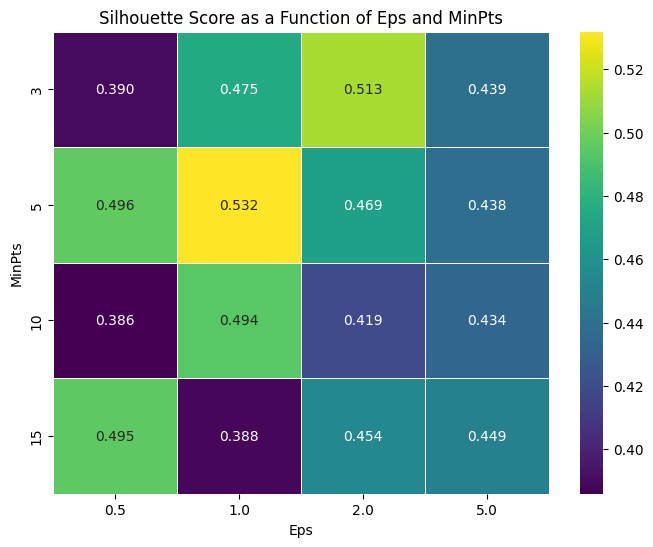

In [185]:
df = pd.DataFrame(evaluation_results)

# Pivot the DataFrame to prepare it for plotting
pivot_df = df.pivot(index='MinPts', columns='Eps', values='silhouette_score')

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.3f', linewidths=0.5)
plt.title('Silhouette Score as a Function of Eps and MinPts')
plt.xlabel('Eps')
plt.ylabel('MinPts')
plt.show()

In [186]:
csv_path = "dbscan_evaluation_results.csv"
evaluation_results.to_csv(csv_path, index=False)  